In [755]:
import pandas as pd
import re
import numpy as np
from scipy import stats

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime

First up is gathering the wait time data. That can be found on [this website](http://www.va.gov/health/access-audit.asp). 

Warning - VA data, according to Jessica Pupovac and [this GAO report](http://www.gao.gov/assets/680/675867.pdf), "is collected somewhat unreliably in some locations." How numbers were collected may be insconsistent from location to location as well as across time. There should be caution about drawing any definitive conclusions from this data, though I believe it is still worth looking at.

I first downloaded the October 13th wait time data for pending appointments. For the purpose of this analysis I'm going to look at completed appointments instead to see if there is a difference.

There is an issue with stations with the same station number. They're few enough that, for the moment, they shouldn't effect the broad analysis. (for example, just deleting all of 657). 

After downloading the PDFs I cleaned them. For the September 2014 completed wait times, I ran the PDF through Tabula and had to do a lot of manual cleaning in excel, including renaming the columns. 

In [769]:
Wait_2014 = pd.read_csv("Wait_Time/Completed_Cleaned/Wait_Times_201409.csv") #for September 2014
Wait_2014.head()


,Location_2014,Appts_2014,Appts_Complete_Over_30_Days_%_2014,PC_Wait_2014,SC_Wait_2014,MH_Wait_2014
0,"(V01) (402) Togus, ME",24458,0.0167,2.72,3.34,1.43
1,"(V01) (405) White River Junction, VT",19232,0.0158,2.24,3.22,0.84
2,"(V01) (518) Bedford, MA",11976,0.0159,0.88,5.30,3.67
3,"(V01) (523) VA Boston HCS, MA",45669,0.0105,1.16,3.17,2.63
4,"(V01) (608) Manchester, NH",17616,0.0163,2.49,3.65,3.01


This is a function that uses regular expressions to extract the station from the location column. 

In [770]:
def get_station(new_string):
    try:
        query = r"^\((V\d\d)\) \((\d\d\d)"
        m = re.search(query, new_string)
        return m.group(2)
    except:
        None

In [771]:
Wait_2014["Station"] = Wait_2014["Location_2014"].apply(get_station)


To remove any duplicates that would cause problems for the analysis, I ran the following code.

In [772]:
Wait_2014 = Wait_2014.drop_duplicates("Station", keep=False)

Now to import 2016.

In [773]:
Wait_2016 = pd.read_csv("Wait_Time/Completed_Cleaned/Wait_Times_201608.csv") #For August 2016
Wait_2016.head()


,Location_2016,Appts_2016,Appts_Complete_Over_30_Days_%_2016,PC_Wait_2016,SC_Wait_2016,MH_Wait_2016
0,"(V01) (402) Togus, ME",28683.0,0.0134,4.96,2.73,1.87
1,(V01) (402) Togus VAMC,17464.0,0.0163,5.96,2.66,2.59
2,(V01) (402GA) Aroostook County\r(Caribou),756.0,0.0423,8.84,0.00,3.41
3,(V01) (402GB) Calais,379.0,0.0000,1.43,0.00,0.36
4,(V01) (402GC) Rumford,428.0,0.0000,1.31,0.00,1.11


For this csv, it's easier to remove the facilities in pandas than the manual clean up I did for 2014. Since the station is always listed before the facility, I can just keep the first instance of a station ID and remove the rest (any duplicates here will be droped when I merge this with 2014).

In [774]:
def get_unique_station(new_list):

    container = []
    return_list = []
    for item in new_list:
        if item in container:
            return_list.append(False)
        else:
            container.append(item)
            return_list.append(True)
    return return_list
Wait_2016["Station"] = Wait_2016["Location_2016"].apply(get_station)
Wait_2016["Is_Station"] = get_unique_station(Wait_2016["Station"])
Wait_2016 = Wait_2016[Wait_2016["Is_Station"]==True]
Wait_2016 = Wait_2016.drop("Is_Station",1)

Here I merge the dataframes.

In [776]:
merged_df = Wait_2014.merge(Wait_2016, on="Station")
len(Wait_2016)

131

Now to bring in the number of new employees hired under the Choice Act program. 

In [777]:
Hiring = pd.read_csv("Hiring/Choice VA Hiring - #4 - Choice Act Hires -Fac List.csv")
Hiring_summed = pd.pivot_table(Hiring,index=["Station"],values=["NbrEmps"],aggfunc=np.sum).reset_index()
Hiring_summed = Hiring_summed.rename(columns = {"NbrEmps":"Choice_Hires"})

In [780]:
merged_df = merged_df.merge(Hiring_summed, on="Station")
merged_df.head()

,Location_2014,Appts_2014,Appts_Complete_Over_30_Days_%_2014,PC_Wait_2014,SC_Wait_2014,MH_Wait_2014,Station,Location_2016,Appts_2016,Appts_Complete_Over_30_Days_%_2016,PC_Wait_2016,SC_Wait_2016,MH_Wait_2016,Choice_Hires_x,Choice_Hires_y,Choice_Hires
0,"(V01) (402) Togus, ME",24458,0.0167,2.72,3.34,1.43,402,"(V01) (402) Togus, ME",28683.0,0.0134,4.96,2.73,1.87,23,23,23
1,"(V01) (405) White River Junction, VT",19232,0.0158,2.24,3.22,0.84,405,"(V01) (405) White River Junction, VT",21581.0,0.0177,3.62,4.08,1.32,24,24,24
2,"(V01) (518) Bedford, MA",11976,0.0159,0.88,5.30,3.67,518,"(V01) (518) Bedford, MA",13170.0,0.0115,0.43,6.01,0.76,5,5,5
3,"(V01) (523) VA Boston HCS, MA",45669,0.0105,1.16,3.17,2.63,523,"(V01) (523) VA Boston HCS, MA",46306.0,0.0271,7.47,5.75,2.17,28,28,28
4,"(V01) (608) Manchester, NH",17616,0.0163,2.49,3.65,3.01,608,"(V01) (608) Manchester, NH",18849.0,0.0160,4.99,2.93,2.94,19,19,19


Finally, let's add in the onboard information so we have a sense of how many employees there were in 2016.

In [781]:
staff = pd.read_csv("Staff_Size/Onboard_By_statyion_By_FY.csv")
staff["Station"] = staff["ORGANIZATION"].apply(get_facility)
merged_df = merged_df.merge(staff, on="Station")
merged_df["Choice_Increase_%"] = merged_df["Choice_Hires"]/merged_df["MAY-FY14"]

This plot is to see how the number of completed appointments in 2014 compares to 2016.

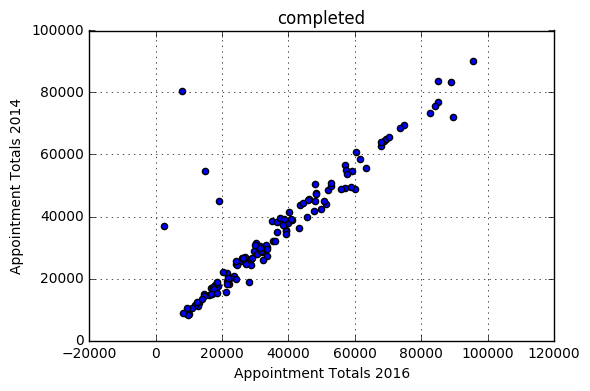

In [783]:
ax = merged_df.plot(kind ='scatter',x='Appts_2016', y ="Appts_2014")
ax.set_title("completed")
ax.set_xlabel("Appointment Totals 2016")
ax.set_ylabel("Appointment Totals 2014")
ax.grid(True)



In [791]:
merged_df["Appts_Increase"] = merged_df["Appts_2016"] - merged_df["Appts_2014"]
merged_df["Appts_Increase"].describe()

count      123.000000
mean      1116.991870
std       9299.580013
min     -72548.000000
25%         27.500000
50%       1823.000000
75%       4126.500000
max      17594.000000
Name: Appts_Increase, dtype: float64

This was a really biazre finding. 2014 and 2016 totals seem to be pretty similar, just with a slight increase. But when I looked at the pending numbers, not the completed numbers, there was a huge jump between 2014 and 2016, as shown below. 

pending.csv is from a previous notebook and analysis that will be uploaded soon.

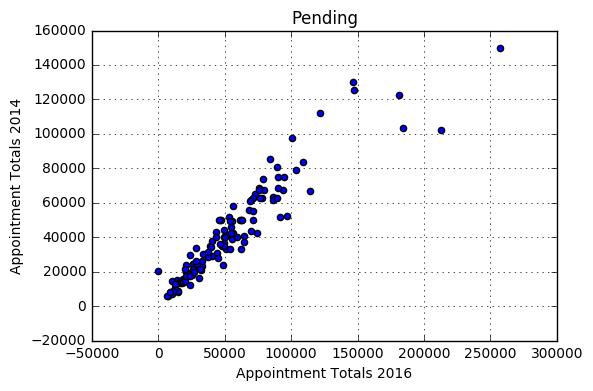

In [785]:
pending = pd.read_csv("pending.csv")[["Appts_Total_2016","Station","Appts_Total_2014_x"]]
pending = pending.rename(columns={"Appts_Total_2016":"2016_Pending","Appts_Total_2014_x":"2014_Pending"}).dropna().drop_duplicates(keep=False)
ax = pending.plot(kind ='scatter',x='2016_Pending', y ="2014_Pending")
ax.set_title("Pending")
ax.set_xlabel("Appointment Totals 2016")
ax.set_ylabel("Appointment Totals 2014")
ax.grid(True)

In [787]:
pending["Pending_Increase"] = pending["2016_Pending"] - pending["2014_Pending"]
pending["Pending_Increase"].describe()

count       124.000000
mean      12307.845806
std       17787.954253
min      -20502.120000
25%        3318.250000
50%        7887.000000
75%       15069.500000
max      110496.000000
Name: Pending_Increase, dtype: float64

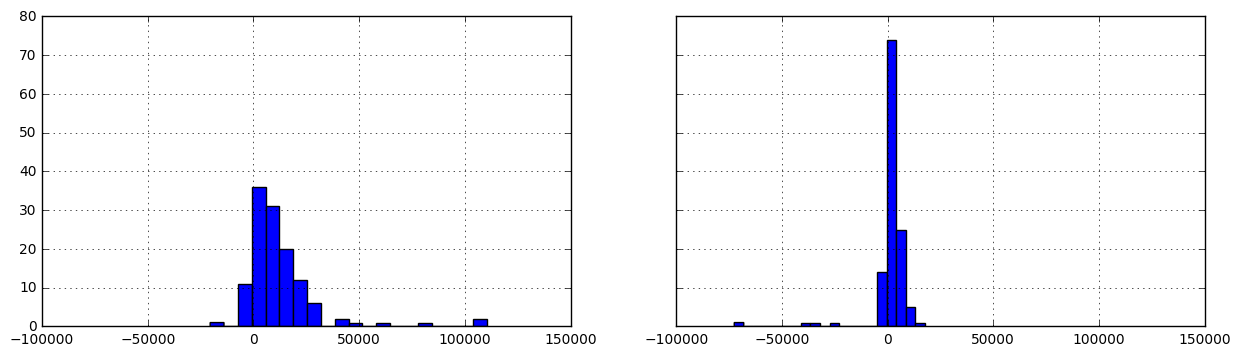

In [792]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,4))
pending["Pending_Increase"].hist(bins=20, ax=ax1)
merged_df["Appts_Increase"].hist(bins=20,ax=ax2)

Let's merge everything together to have a better look.

In [794]:
pending["Station"] = pending["Station"].astype(int).astype(str)
new_merged_df = merged_df.merge(pending, on="Station")
new_merged_df = merged_df.merge(pending, on="Station")
new_merged_df.head(5)

,Location_2014,Appts_2014,Appts_Complete_Over_30_Days_%_2014,PC_Wait_2014,SC_Wait_2014,MH_Wait_2014,Station,Location_2016,Appts_2016,Appts_Complete_Over_30_Days_%_2016,...,MAY-FY12,MAY-FY13,MAY-FY14,MAY-FY15,MAY-FY16,Choice_Increase_%,Appts_Increase,2016_Pending,2014_Pending,Pending_Increase
0,"(V01) (402) Togus, ME",24458,0.0167,2.72,3.34,1.43,402,"(V01) (402) Togus, ME",28683.0,0.0134,...,1272.0,1248,1283,1335,1446,0.017927,4225.0,43609.0,42899.0,710.0
1,"(V01) (405) White River Junction, VT",19232,0.0158,2.24,3.22,0.84,405,"(V01) (405) White River Junction, VT",21581.0,0.0177,...,853.0,881,921,1022,1177,0.026059,2349.0,21091.0,23709.0,-2618.0
2,"(V01) (518) Bedford, MA",11976,0.0159,0.88,5.30,3.67,518,"(V01) (518) Bedford, MA",13170.0,0.0115,...,1265.0,1245,1251,1297,1352,0.003997,1194.0,14456.0,8105.0,6351.0
3,"(V01) (523) VA Boston HCS, MA",45669,0.0105,1.16,3.17,2.63,523,"(V01) (523) VA Boston HCS, MA",46306.0,0.0271,...,4011.0,4041,4032,4123,4303,0.006944,637.0,84373.0,85625.0,-1252.0
4,"(V01) (608) Manchester, NH",17616,0.0163,2.49,3.65,3.01,608,"(V01) (608) Manchester, NH",18849.0,0.0160,...,683.0,691,686,759,803,0.027697,1233.0,25424.0,19511.0,5913.0


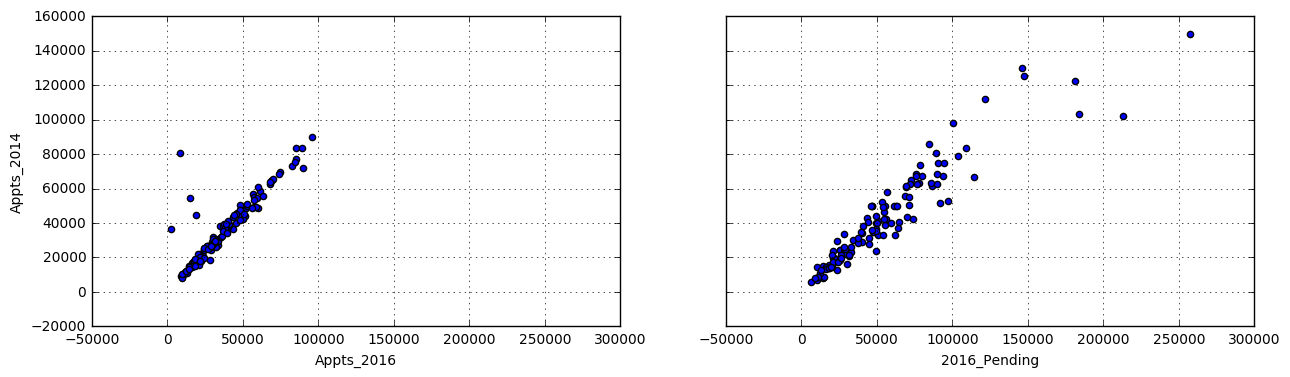

In [795]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(15,4))
new_merged_df.plot(kind ='scatter',x='Appts_2016', y ="Appts_2014", ax=ax1)
ax1.grid(True)
new_merged_df.plot(kind ='scatter',x='2016_Pending', y ="2014_Pending", ax=ax2)
ax2.grid(True)

R-squared: 0.643996305668


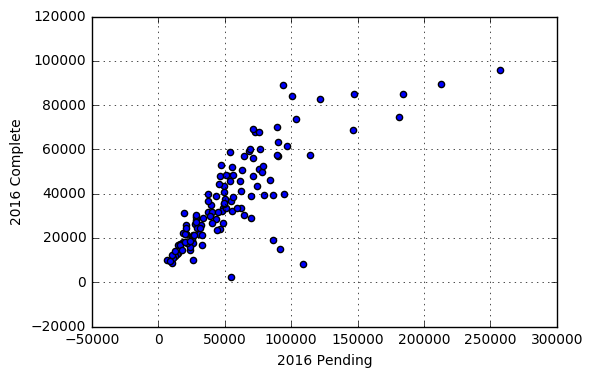

In [796]:
ax = new_merged_df.plot(kind ='scatter',x='2016_Pending', y ="Appts_2016")
ax.set_xlabel("2016 Pending")
ax.set_ylabel("2016 Complete")
ax.grid(True)
slope, intercept, r_value, p_value, std_err = stats.linregress(new_merged_df["2016_Pending"],new_merged_df["Appts_2016"])
print "R-squared: "+ str(r_value**2)

R-squared: 0.805857556063


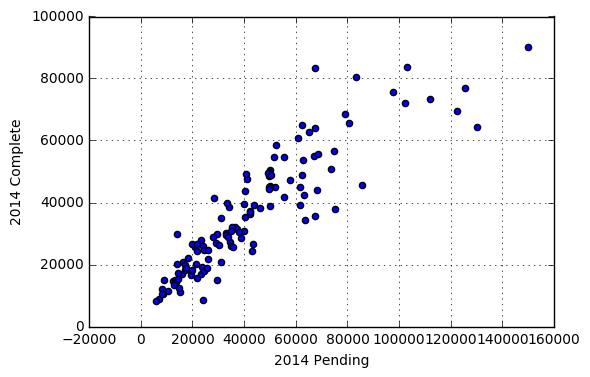

In [797]:
ax = new_merged_df.plot(kind ='scatter',x='2014_Pending', y ="Appts_2014")
ax.set_xlabel("2014 Pending")
ax.set_ylabel("2014 Complete")
ax.grid(True)
slope, intercept, r_value, p_value, std_err = stats.linregress(new_merged_df["2014_Pending"],new_merged_df["Appts_2014"])
print "R-squared: "+ str(r_value**2)


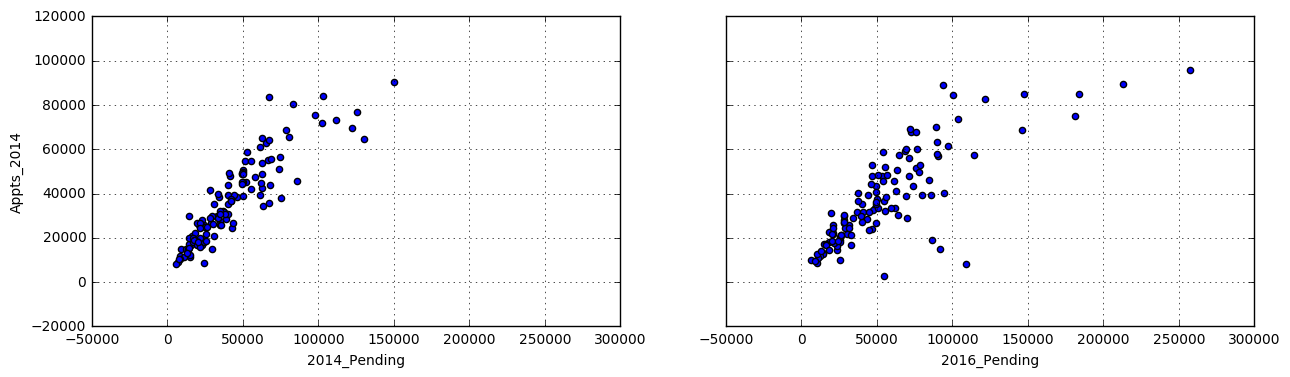

In [620]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(15,4))
new_merged_df.plot(kind ='scatter',x='2014_Pending', y ="Appts_2014", ax=ax1)
ax1.grid(True)
new_merged_df.plot(kind ='scatter',x='2016_Pending', y ="Appts_2016", ax=ax2)
ax2.grid(True)

In [621]:
old = new_merged_df["Appts_2014"]
new = new_merged_df["Appts_2016"]
increase = new - old
new_merged_df["Completed_Increase_%"] = (increase/old)*100
new_merged_df["Completed_Increase_%"].describe()

count    122.000000
mean       4.753065
std       17.908367
min      -93.120587
25%        0.311788
50%        6.505453
75%       12.021643
max       49.858538
Name: Completed_Increase_%, dtype: float64

In [622]:
old = new_merged_df["2014_Pending"]
new = new_merged_df["2016_Pending"]
increase = new - old
new_merged_df["Completed_Increase_%"] = (increase/old)*100
new_merged_df["Completed_Increase_%"].describe()

count    122.000000
mean      28.767711
std       25.934822
min      -30.131955
25%       11.451753
50%       24.327803
75%       40.060785
max      107.967403
Name: Completed_Increase_%, dtype: float64

## This is where I start looking at the national numbers

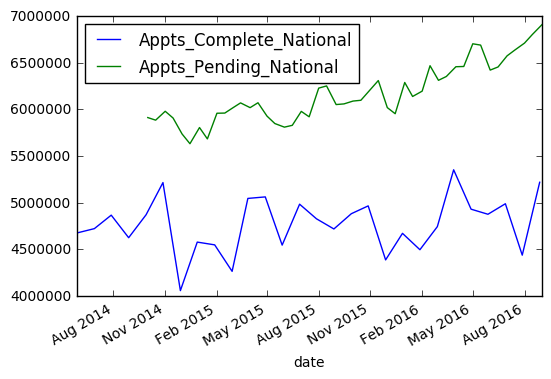

In [707]:
#Taken from VA site
national_complete = pd.read_csv("Wait_Time/Completed_Cleaned/National_Complete.csv")
national_pending = pd.read_csv("Wait_Time/Pending_Clean/National_Pending.csv")


#used to strip time from Pending_Time
def get_date(test):
    test = test.strip('National: ')
    return parser.parse(test)

national_complete["date"] = national_complete["Complete_Time"].apply(get_date)
national_pending["date"] = national_pending["Pending_Time"].apply(get_date)
national_pending = national_pending.drop(20) #for some reason this was read in as 1989. Just dropping it

NC = national_complete[["Appts_Complete_National","date"]]
NP = national_pending[["Appts_Pending_National","date"]]

ax = NC.set_index("date").plot()
NP.set_index("date").plot(ax=ax)

Interesting. It looks like pending is increasing while complete remains mostly flat. 

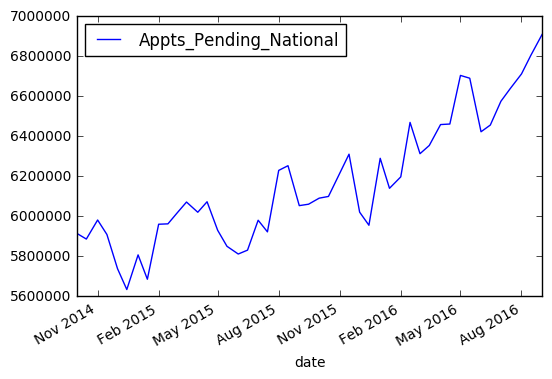

In [634]:
ax = NP.set_index("date").plot()
#In case we want to look at them individually

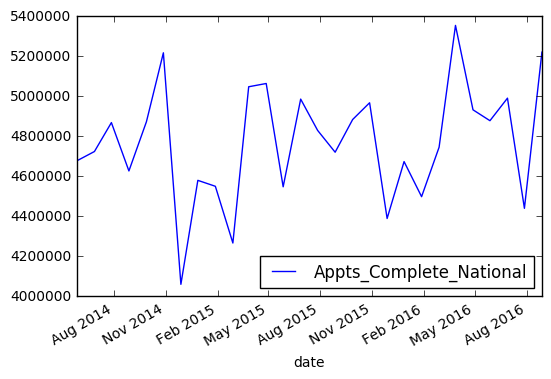

In [635]:
ax = NC.set_index("date").plot()


I want to see the difference between completed appointments and pending appointments but they don't use the same dates. So I'm going to get the mean for each month and then compare months, though I'll have to combine months and years.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


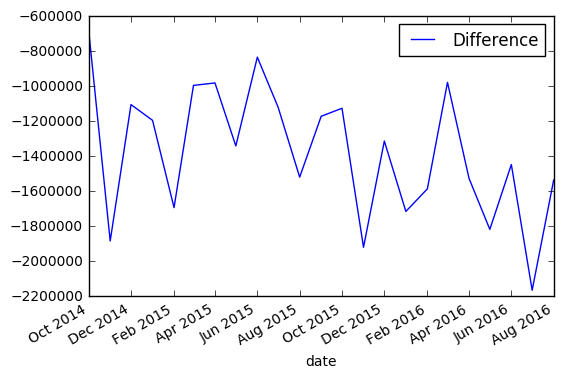

In [798]:
def get_month_year(test):
    return str(test.month) + "_"+str(test.year)
NP["month_year"] = NP["date"].apply(get_month_year)
NC["month_year"] = NC["date"].apply(get_month_year)
NP_Months = pd.pivot_table(NP, index="month_year",values=["Appts_Pending_National"],aggfunc = np.mean).reset_index()
NC_Months = pd.pivot_table(NC, index="month_year",values=["Appts_Complete_National"],aggfunc = np.mean).reset_index()
PC_merged = NC_Months.merge(NP_Months, on="month_year")
PC_merged["Difference"] = PC_merged["Appts_Complete_National"] - PC_merged["Appts_Pending_National"]
def get_back_time(test):
    return datetime.strptime(test,'%m_%Y')
PC_merged["date"] = PC_merged["month_year"].apply(get_back_time)
ax = PC_merged[["Difference","date"]].set_index("date").plot()

Let's look at the same graph, but as a percent difference.

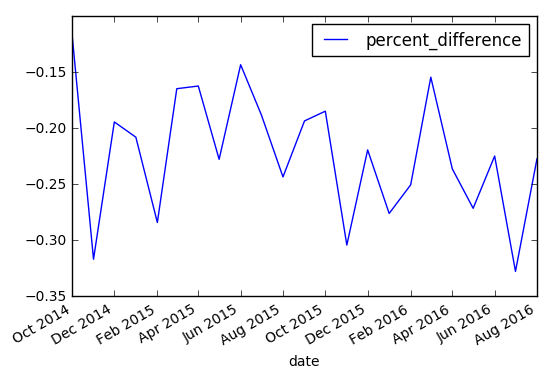

In [799]:
PC_merged["percent_difference"] = PC_merged["Difference"]/PC_merged["Appts_Pending_National"]
ax = PC_merged[["percent_difference","date"]].set_index("date").plot()

## Let's get back to checking previous findings

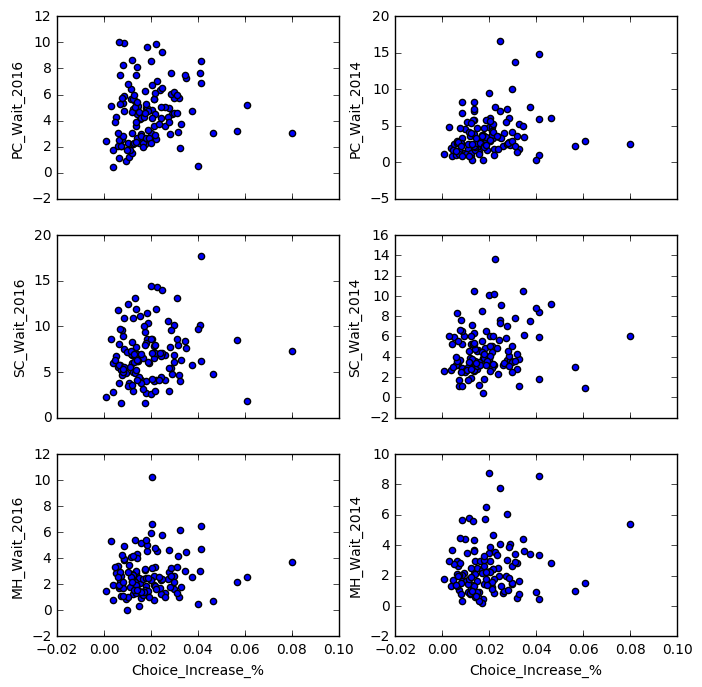

In [629]:
#Did Wait times affect choice hires?

fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(8,8))
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="PC_Wait_2016", ax=ax1)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="PC_Wait_2014", ax=ax2)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="SC_Wait_2016", ax=ax3)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="SC_Wait_2014", ax=ax4)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="MH_Wait_2016", ax=ax5)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="MH_Wait_2014", ax=ax6)

There does not appear to be any corelation between hires and wait times, be it raw numbers or adjusted.

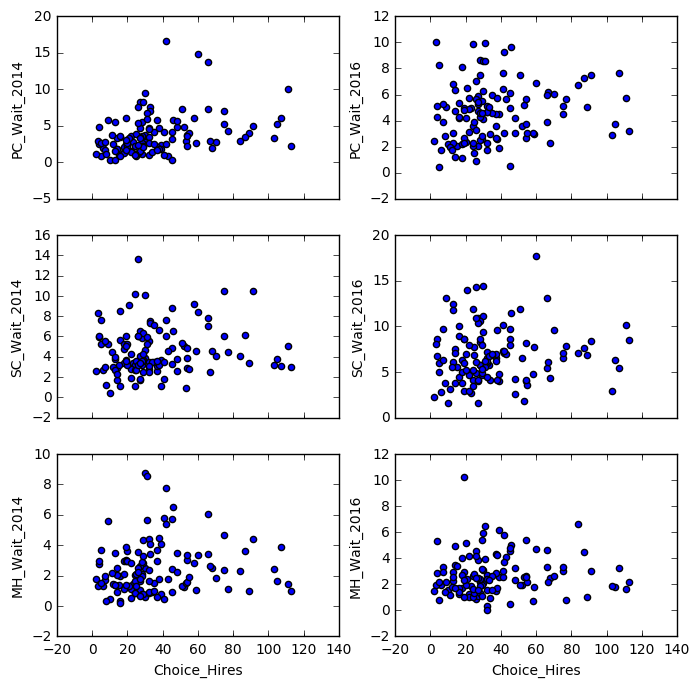

In [749]:
#What about looking at the raw numbers?

fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(8,8))
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="PC_Wait_2014", ax=ax1)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="PC_Wait_2016", ax=ax2)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="SC_Wait_2014", ax=ax3)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="SC_Wait_2016", ax=ax4)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="MH_Wait_2014", ax=ax5)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="MH_Wait_2016", ax=ax6)

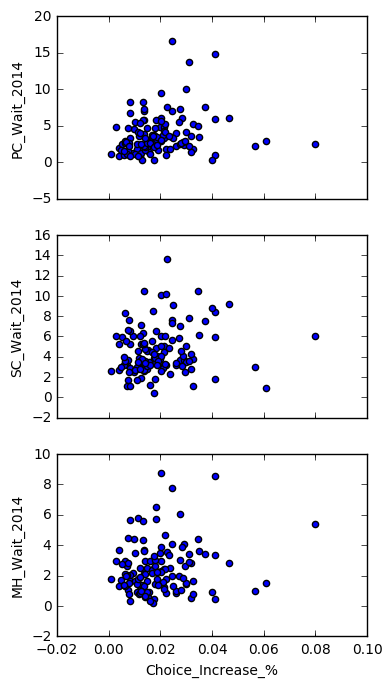

In [750]:
fig, ((ax1), (ax2),(ax3)) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(4,8))
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="PC_Wait_2014", ax=ax1)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="SC_Wait_2014", ax=ax2)
new_merged_df.plot(kind ='scatter',x='Choice_Increase_%', y ="MH_Wait_2014", ax=ax3)

In [631]:
#Different view - how wait times have changed

new_merged_df["PC_Wait_Changed"] = new_merged_df["PC_Wait_2016"] - new_merged_df["PC_Wait_2014"]
new_merged_df["SC_Wait_Changed"] = new_merged_df["SC_Wait_2016"] - new_merged_df["SC_Wait_2014"]
new_merged_df["MH_Wait_Changed"] = new_merged_df["MH_Wait_2016"] - new_merged_df["MH_Wait_2014"]

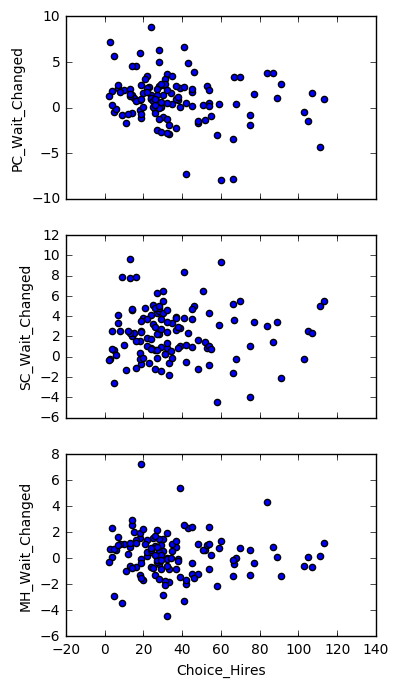

In [632]:
fig, ((ax1), (ax2),(ax3)) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(4,8))
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="PC_Wait_Changed", ax=ax1)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="SC_Wait_Changed", ax=ax2)
new_merged_df.plot(kind ='scatter',x='Choice_Hires', y ="MH_Wait_Changed", ax=ax3)


#### Testing a small multiple 

In [800]:
# May take a small multiples look later on. 
test = new_merged_df[51:52]

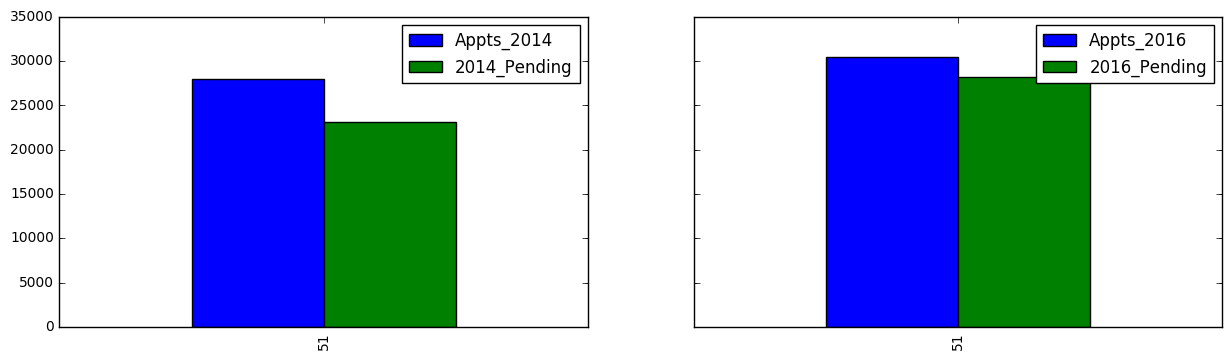

In [690]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(15,4))
test[["Appts_2014","2014_Pending"]].plot(kind="bar", ax = ax1)
test[["Appts_2016","2016_Pending"]].plot(kind="bar", ax = ax2)

### Looking at national wait times

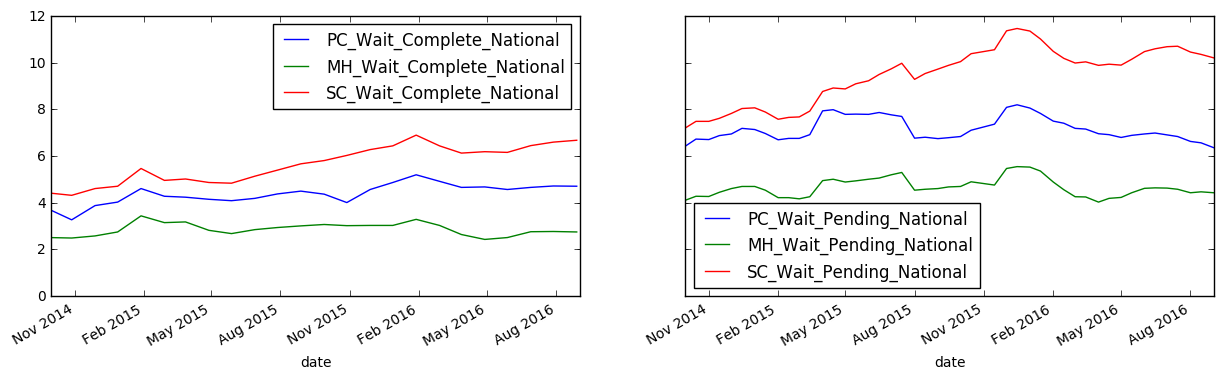

In [801]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,4))

national_complete[["date","PC_Wait_Complete_National"]].set_index("date").plot(ax=ax1)
national_complete[["date","MH_Wait_Complete_National"]].set_index("date").plot(ax=ax1)
national_complete[["date","SC_Wait_Complete_National"]].set_index("date").plot(ax=ax1)

national_pending[["date","PC_Wait_Pending_National"]].set_index("date").plot(ax=ax2)
national_pending[["date","MH_Wait_Pending_National"]].set_index("date").plot(ax=ax2)
national_pending[["date","SC_Wait_Pending_National"]].set_index("date").plot(ax=ax2)


Pending and complete wait times are different for some reason. 

When we look at wait times next to appointments, they don't appear to correlate well. 

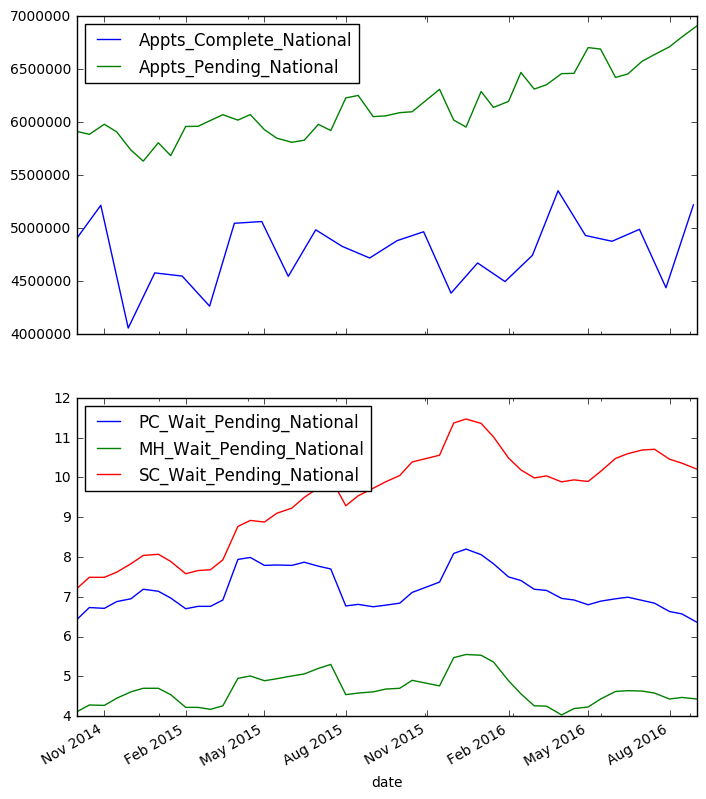

In [802]:
fig, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,10))

NC.set_index("date").plot(ax=ax1)
NP.set_index("date").plot(ax=ax1)



national_pending[["date","PC_Wait_Pending_National"]].set_index("date").plot(ax=ax2)
national_pending[["date","MH_Wait_Pending_National"]].set_index("date").plot(ax=ax2)
national_pending[["date","SC_Wait_Pending_National"]].set_index("date").plot(ax=ax2)

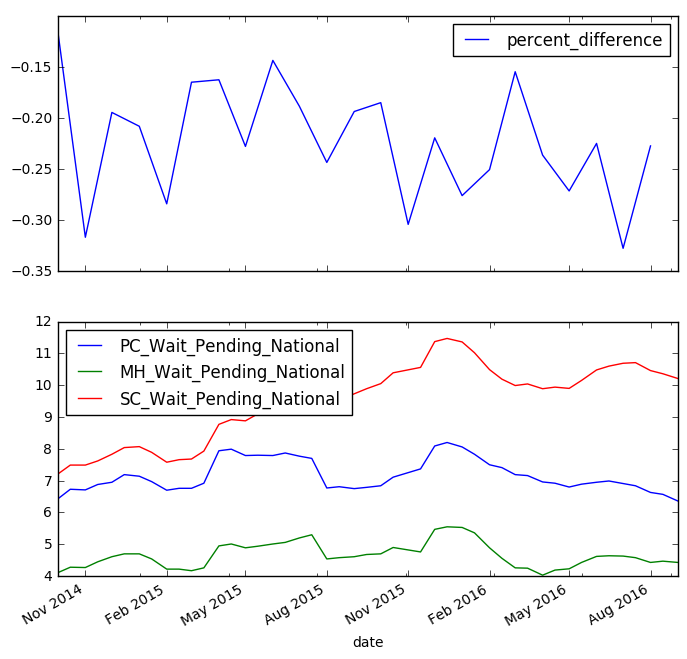

In [803]:
fig, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8))

PC_merged[["percent_difference","date"]].set_index("date").plot(ax=ax1)


national_pending[["date","PC_Wait_Pending_National"]].set_index("date").plot(ax=ax2)
national_pending[["date","MH_Wait_Pending_National"]].set_index("date").plot(ax=ax2)
national_pending[["date","SC_Wait_Pending_National"]].set_index("date").plot(ax=ax2)

KeyError: 'PC_Wait_Pending_National'

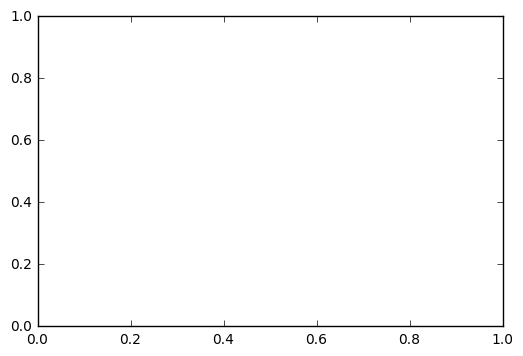

In [805]:
#code not working yet, need to change how I merge
ax = PC_merged.plot(kind ='scatter',x='PC_Wait_Pending_National', y ="percent_difference")

ax.grid(True)
slope, intercept, r_value, p_value, std_err = stats.linregress(PC_merged["PC_Wait_Pending_National"],PC_merged["percent_difference"])
print "R-squared: "+ str(r_value**2)